# Processing pupil size data and epoching

In recordings with events of interest, we often want to extract the data around these events and perform analysis on them instead of the entire recording. In mobile eye-tracking, such events can be the presentation of a stimulus, or the participant walking into a certain area. In this notebook, we will demonstrate how to epoch data around these events using the `pyneon.Epochs` class with a simple recording `screenFlash`.

In [15]:
import numpy as np
from pyneon import Recording, get_sample_data

# create a Recording object
rec_dir = (
    get_sample_data("screenFlash")
    / "Timeseries Data + Scene Video"
    / "screenflash-54b2f924"
)
rec = Recording(rec_dir)
video = rec.video
blinks = rec.blinks
events = rec.events
eye_states = rec.eye_states

This recording consists of a participant looking at a screen flashing from black to white (duration = 0.75 s), separated by 3 seconds. We expect the pupils to constrict following a flash, before returning to baseline. thus, it makes for a good test case of the epoching function. Here's how the flash looks like to the participant:

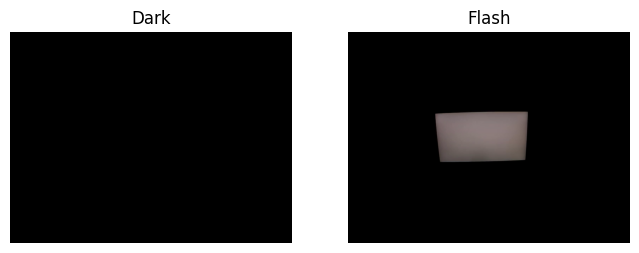

In [16]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(8, 3))
video.plot_frame(180, ax=axs[0], auto_title=False, show=False)
video.plot_frame(190, ax=axs[1], auto_title=False, show=False)
axs[0].set_title("Dark")
axs[1].set_title("Flash")
plt.show()

To inspect raw data, we plot the pupil size throughout the recording along with blinks. Shaded area represents times when the screen turned bright. Dotted lines represent blink onset.

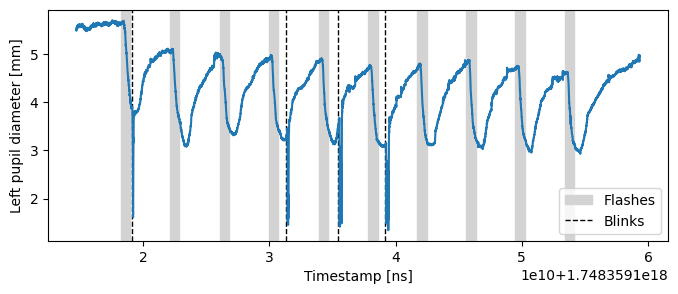

In [17]:
# Create a figure
plt.figure(figsize=(8, 3))

# Visualize the flashes
flash_idx = np.where(events.data["name"] == "Flash onset")
for flash_start in events.start_ts[flash_idx]:
    dur = plt.axvspan(
        flash_start, flash_start + 0.75 * 1e9, color="lightgray", label="Flashes"
    )  # Each flash lasts 2 seconds

# Visualize the blinks
for blink_start in blinks.start_ts:
    line = plt.axvline(blink_start, color="k", linestyle="--", lw=1, label="Blinks")

# Plot the pupil data
(pupil_l,) = plt.plot(eye_states["pupil diameter left [mm]"])

plt.xlabel("Timestamp [ns]")
plt.ylabel("Left pupil diameter [mm]")
plt.legend(handles=[dur, line])
plt.show()

From the plot we can see:
- Pupil size decreases after each alteration of the screen brightness.
- The participant tends to blink in response to each flash, and the blinks induce a transient artifact in pupil size
 
First we will repair blink artifacts using the `interpolate_events()` method of the `Stream` class. It nullifies data during events (blinks in this case) and interpolates data around them. The artifacts are visibly removed after the operation:

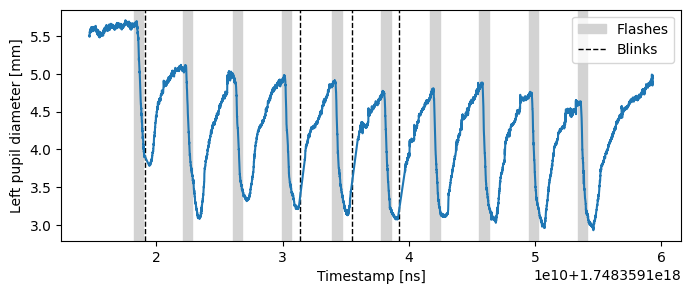

In [18]:
eye_states.interpolate_events(blinks, inplace=True)

# Create a figure
plt.figure(figsize=(8, 3))

# Visualize the flashes
flash_idx = np.where(events.data["name"] == "Flash onset")
for flash_start in events.start_ts[flash_idx]:
    dur = plt.axvspan(
        flash_start, flash_start + 7.5 * 1e8, color="lightgray", label="Flashes"
    )  # Each flash lasts 2 seconds

# Visualize the blinks
for blink_start in blinks.start_ts:
    line = plt.axvline(blink_start, color="k", linestyle="--", lw=1, label="Blinks")

# Plot the pupil data
(pupil_l,) = plt.plot(eye_states["pupil diameter left [mm]"])

plt.xlabel("Timestamp [ns]")
plt.ylabel("Left pupil diameter [mm]")
plt.legend(handles=[dur, line])
plt.show()

Now with the data repaired and a good trend observed, we can epoch the data around the screen flashes to quantify the pupil size response.

## Create an times_df DataFrame

In order to perform epoching, we require information about the timing and lenghts of epochs. Explicitly, every epoch requires a reference time `t_ref`, a time window defined by `t_before` and `t_after` to extract the data from, and an event `description` to annotate the epoch. Due to the dynamic nature of mobile eye-tracking, PyNeon `Epochs` allows for unequal epoch lengths, meaning that `t_before` and `t_after` can be different for each epoch. Therefore, the full specification of the epochs requires a DataFrame called `times_df` with `t_ref`, `t_before`, `t_after` and `description` columns.

While it is possible to create such a DataFrame manually, we can go the easier way and use event information from PyNeon `Events` objects. The `events_to_times_df` function allows us to easily construct a `times_df` DataFrame by taking the onsets of (a subset of) events and defining uniform epoch `t_before` and `t_after` values.

In our example, we use `"Flash onset"` events to define a `times_df`. We extract 2 seconds before and 2 seconds after the event, and the descriptions are automatically set to the event name.

In [19]:
from pyneon import events_to_times_df, Epochs


# For complex events, such as those from `events.csv`, we need to specify the event name
flash_times_df = events_to_times_df(
    events, t_before=0.5, t_after=3, t_unit="s", event_name="Flash onset"
)

# Visualize the epoching-ready times_df
print("\nFlash times DataFrame:")
print(flash_times_df.head())


Flash times DataFrame:
                 t_ref   t_before     t_after  description
0  1748359118207381000  500000000  3000000000  Flash onset
1  1748359122083310000  500000000  3000000000  Flash onset
2  1748359126042722000  500000000  3000000000  Flash onset
3  1748359129933171000  500000000  3000000000  Flash onset
4  1748359133927133000  500000000  3000000000  Flash onset


## Creating Epochs

Once we have the `times_df` DataFrame, we can create epochs simply by passing it along with the `Stream`/`Events` objects we want to epoch from to the `Epochs` class. Here, we care about pupil diameter, which is included in `eye_states`.

In [20]:
# Create an Epoch with times_df in one line
eye_ep = Epochs(eye_states, flash_times_df)
blink_ep = Epochs(blinks, flash_times_df)
print(f"{len(eye_ep)} epochs created from {len(flash_times_df)} events")

10 epochs created from 10 events


C:\Users\qian.chu\Documents\GitHub\PyNeon\pyneon\epochs.py:440: RuntimeWarning: No data found for epoch 1.
  warnings.warn(f"No data found for epoch {i}.", RuntimeWarning)
C:\Users\qian.chu\Documents\GitHub\PyNeon\pyneon\epochs.py:440: RuntimeWarning: No data found for epoch 2.
  warnings.warn(f"No data found for epoch {i}.", RuntimeWarning)
C:\Users\qian.chu\Documents\GitHub\PyNeon\pyneon\epochs.py:440: RuntimeWarning: No data found for epoch 6.
  warnings.warn(f"No data found for epoch {i}.", RuntimeWarning)
C:\Users\qian.chu\Documents\GitHub\PyNeon\pyneon\epochs.py:440: RuntimeWarning: No data found for epoch 7.
  warnings.warn(f"No data found for epoch {i}.", RuntimeWarning)
C:\Users\qian.chu\Documents\GitHub\PyNeon\pyneon\epochs.py:440: RuntimeWarning: No data found for epoch 8.
  warnings.warn(f"No data found for epoch {i}.", RuntimeWarning)
C:\Users\qian.chu\Documents\GitHub\PyNeon\pyneon\epochs.py:440: RuntimeWarning: No data found for epoch 9.
  warnings.warn(f"No data found f

The `Epochs` class has two key attributes: `epochs` and `data`. For details, see the [API reference](https://ncc-brain.github.io/PyNeon/reference/epochs.html).

`Epochs.epochs` is a nested DataFrame indexed by the epoch number. Data that belong to the epoch are stored in the `data` column.

In [21]:
print(f"Epochs.epochs contains:\n{eye_ep.epochs.columns}\n")
print(f"Its `data` column contains:\n{eye_ep.epochs.data[0].columns}\n")

Epochs.epochs contains:
Index(['t_ref', 't_before', 't_after', 'description', 'data'], dtype='object')

Its `data` column contains:
Index(['pupil diameter left [mm]', 'pupil diameter right [mm]',
       'eyeball center left x [mm]', 'eyeball center left y [mm]',
       'eyeball center left z [mm]', 'eyeball center right x [mm]',
       'eyeball center right y [mm]', 'eyeball center right z [mm]',
       'optical axis left x', 'optical axis left y', 'optical axis left z',
       'optical axis right x', 'optical axis right y', 'optical axis right z',
       'eyelid angle top left [rad]', 'eyelid angle bottom left [rad]',
       'eyelid aperture left [mm]', 'eyelid angle top right [rad]',
       'eyelid angle bottom right [rad]', 'eyelid aperture right [mm]',
       'epoch time'],
      dtype='object')



`Epochs.data` (not to be confused with the `data` column in `Epochs.epochs`) is a DataFrame that inherits the source DataFrame's index and columns. It can be thought of as a "epoch-annotated" version of the source DataFrame, and has 3 additional columns:
- `epoch index`: index of the epoch this row belongs to (NaN if it doesn't belong to any epoch, same below)
- `epoch time`: time of the row relative to the epoch reference time
- `epoch description`: description of the epoch this row belongs to

As a flattened version of `Epochs.epochs`, `Epochs.data` however could suffer from overlapping epochs. In this case, the additional columns will only reflect the information of the last epoch that the time point belongs to. For this reason, we recommend mostly using `Epochs.epochs` for analysis.

## Plotting epoch data

Plotting data from individual epochs is easy with the `plot()` method. We simply need to specify which column we want to plot.

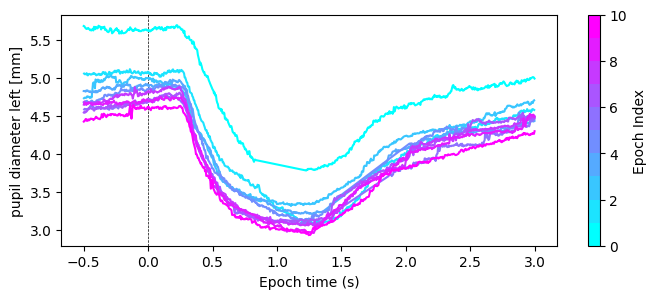

(<Figure size 800x300 with 2 Axes>,
 <Axes: xlabel='Epoch time (s)', ylabel='pupil diameter left [mm]'>)

In [22]:
fig, ax = plt.subplots(figsize=(8, 3))
eye_ep.plot("pupil diameter left [mm]", ax=ax)

The individual epochs' data promisingly show a decrease in pupil size after the screen flash. However, it might be tricky to perform proper statistical tests. 

In [23]:
# bin the data into 10 ms bins
window_size = int(1e7)  # ns to ms
# find the minimum and maximum time of the epoch
min_time = eye_ep.data["epoch time"].min()
max_time = eye_ep.data["epoch time"].max()
# find the number of bins

binned_data = []

for time in range(min_time, max_time, window_size):
    # find the indices of the data that are in the bin
    indices = eye_ep.data[
        (eye_ep.data["epoch time"] >= time)
        & (eye_ep.data["epoch time"] < time + window_size)
    ].index
    # find the mean pupil diameter of the data in the bin
    mean_pupil = eye_ep.data.loc[indices, "pupil diameter left [mm]"].mean()
    # find the mean time of the data in the bin
    mean_time = eye_ep.data.loc[indices, "epoch time"].mean()
    # append the mean time and mean pupil diameter to the binned data
    binned_data.append([mean_time, mean_pupil])

yuck

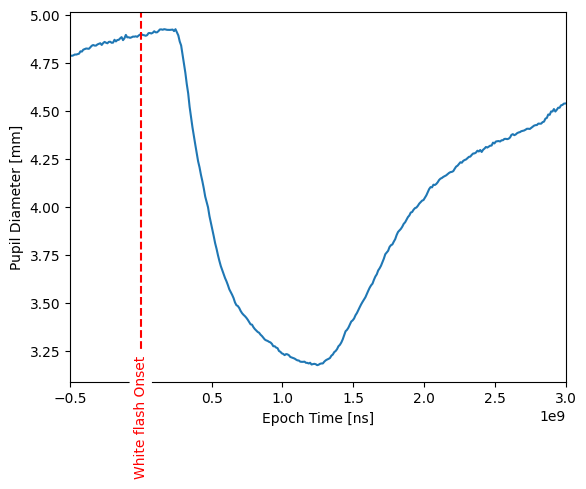

In [24]:
# Convert binned_data to a numpy array for easier indexing
binned_data = np.array(binned_data)

# Plot the binned data
plt.plot(binned_data[:, 0], binned_data[:, 1])

plt.xlim(-5e8, 3e9)  # Adjust x-axis limits to match the epoch time range in nanoseconds
plt.axvline(x=0, color="r", linestyle="--")  # Show a vertical line at 0
plt.text(
    0,
    2.6,
    "White flash Onset",
    color="r",
    ha="center",
    rotation=90,
    bbox=dict(facecolor="white", edgecolor="none", boxstyle="round,pad=0.3"),
)
# Add x and y labels
plt.xlabel("Epoch Time [ns]")
plt.ylabel("Pupil Diameter [mm]")
plt.show()

Indeed, we can see that pupil size shrinks after stimulus onset, exactly as hoped. However, let's address the implementation of the rolling average by transforming the problem to a different formulation.

## Step 5: NumPy arrays

Instead of thinking about epochs as a DataFrame with annotated epoch info, we can transform it into a 3-dimensional array with dimensions (n_epochs, n_channels, n_times). In this formulation, every epoch, data channel and epoch time can be accessed by provididing the right coordinate. Also, functions can be executed along axes of this array, simplifying everything a lot.

In order to define such an epochs object, we need to interpolate the underlying NeonStream. Otherwise, there is no unique value for n_times, as these may differ between unequally sampled epochs. 

In [25]:
try:
    epochs_interp_np, info = eye_ep.to_numpy()
except Exception as e:
    print(f"Error converting to numpy: {e}")

Error converting to numpy: The source must be a uniformly-sampled Stream to convert to NumPy array.


Handily, PyNeon raises an Error if we try to transform a non-uniformly sampled stream.

So, let's do it properly instead:

In [26]:
# create an epoch with the interpolated data
epochs_interp = Epochs(eye_states.interpolate(), flash_times_df)
epochs_interp_np, info = epochs_interp.to_numpy()

print(epochs_interp_np.shape)
print(info.keys())

(10, 20, 699)
dict_keys(['column_ids', 'epoch_times', 'nan_flag'])


C:\Users\qian.chu\Documents\GitHub\PyNeon\pyneon\epochs.py:273: RuntimeWarning: NaN values were found in the data.
  warnings.warn("NaN values were found in the data.", RuntimeWarning)


We can see that we have 10 epochs with 20 data chanels and 799 epoch times. This number arises from the nominal sampling frequency of the gaze datastream, 200Hz, and the window size of 4 sec.
Additionally, we get the info object that provides us with a dictionary containing lists of column_ids and epoch times. With this, the gand average boils down to a single function call:

Text(0, 0.5, 'Pupil Diameter [mm]')

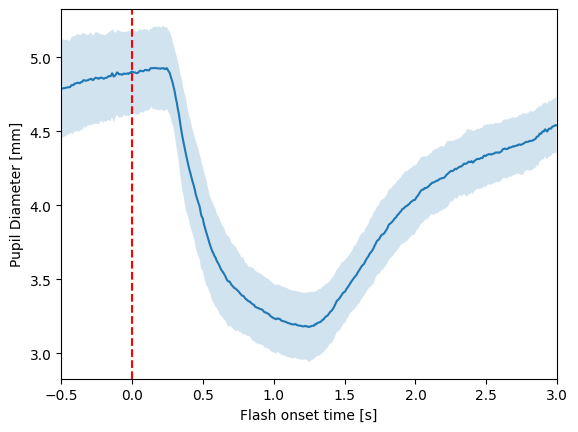

In [27]:
# average across all epochs
pupil_mean = epochs_interp_np[:, 0, :].mean(axis=0)
pupil_std = epochs_interp_np[:, 0, :].std(axis=0)

# plot the mean pupil diameter and standard deviation
plt.plot(info["epoch_times"], pupil_mean, label="mean")
plt.fill_between(
    info["epoch_times"],
    pupil_mean - pupil_std,
    pupil_mean + pupil_std,
    alpha=0.2,
    label="std",
)
plt.xlim(-.5, 3)
# show a vertical line at 0
plt.axvline(x=0, color="r", linestyle="--")

# add x and y labels
plt.xlabel("Flash onset time [s]")
plt.ylabel("Pupil Diameter [mm]")

## Step 6 - Baseline Correction

Lastly, we can perform simple baseline corrections of the data, thereby focusing on changes rather than absolute values. To do so, we define the baseline period and the method we want to use, recompute the numpy array, and plot

C:\Users\qian.chu\Documents\GitHub\PyNeon\pyneon\epochs.py:273: RuntimeWarning: NaN values were found in the data.
  warnings.warn("NaN values were found in the data.", RuntimeWarning)


Text(0, 0.5, 'Pupil Diameter [mm]')

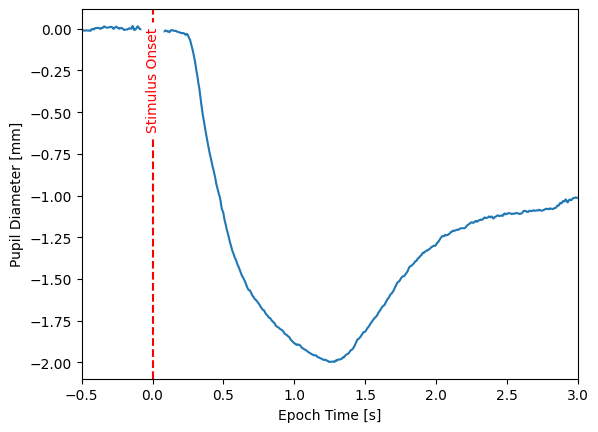

In [28]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    baseline = epochs_interp.baseline_correction(
        inplace=True, baseline=(-1, 0.0), method="linear"
    )
epochs_interp_np, info = epochs_interp.to_numpy()

# average across all epochs
pupil_mean = epochs_interp_np[:, 0, :].mean(axis=0)


# plot the mean pupil diameter and standard deviation
plt.plot(info["epoch_times"], pupil_mean, label="mean")
plt.xlim(-.5, 3)
# show a vertical line at 0
plt.axvline(x=0, color="r", linestyle="--")
plt.text(
    0,
    -0.6,
    "Stimulus Onset",
    color="r",
    ha="center",
    rotation=90,
    bbox=dict(facecolor="white", edgecolor="none", boxstyle="round,pad=0.3"),
)
# add x and y labels
plt.xlabel("Epoch Time [s]")
plt.ylabel("Pupil Diameter [mm]")